In [1]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
# get titanic & test csv files as a DataFrame
titanic_df = pd.read_csv("../input/train.csv", dtype={"Age": np.float64}, )
test_df    = pd.read_csv("../input/test.csv", dtype={"Age": np.float64}, )

# preview the data
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
titanic_df.info()
print("----------------------------")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare

In [4]:
import re

def create_title_classes(df):
    df['Mil'] = np.where((df['Name'].str.contains('Capt') | df['Name'].str.contains('Maj') | df['Name'].str.contains('Col\.')), 1, 0)
    df['Rev'] = np.where(df['Name'].str.contains('Rev'), 1, 0)
    df['Dr'] = np.where(df['Name'].str.contains('Dr\.'), 1, 0) 
    df['Master'] = np.where(df['Name'].str.contains('Master'), 1, 0) 
    df['Mrs'] = np.where(df['Name'].str.contains('Mrs\.') | df['Name'].str.contains('Mme\.'), 1, 0) 
    df['Mr'] = np.where(df['Name'].str.contains('Mr\.') | ((df['Sex'] == 'male') & (df['Dr'] == 0) & (df['Mil'] == 0) & (df['Rev'] == 0) & (df['Master'] == 0)),1,0)
    df['Miss'] = np.where(df['Name'].str.contains('Miss') | ((df['Sex'] == 'female') & (df['Dr'] == 0) & (df['Mrs'] == 0)), 1, 0) 

    print "Number of Mr.: %d " % len(df[df['Mr'] == 1])
    print "Number of Mrs.: %d " % len(df[df['Mrs'] == 1])
    print "Number of Miss: %d " % len(df[df['Miss'] == 1])
    print "Number of Dr.: %d " % len(df[df['Dr'] == 1])
    print "Number of Master: %d " % len(df[df['Master'] == 1])
    print "Number of Reverends: %d " % len(df[df['Rev'] == 1])
    print "Number of Military Officers: %d " % len(df[df['Mil'] == 1])
    print "Total number of people: %d " % len(df)

create_title_classes(titanic_df)
create_title_classes(test_df)

Number of Mr.: 520 
Number of Mrs.: 126 
Number of Miss: 187 
Number of Dr.: 7 
Number of Master: 40 
Number of Reverends: 6 
Number of Military Officers: 5 
Total number of people: 891 
Number of Mr.: 240 
Number of Mrs.: 72 
Number of Miss: 80 
Number of Dr.: 1 
Number of Master: 21 
Number of Reverends: 2 
Number of Military Officers: 2 
Total number of people: 418 


In [5]:
# drop unnecessary columns, these columns won't be useful in analysis and prediction
titanic_df = titanic_df.drop(['PassengerId','Name','Ticket'], axis=1)
test_df    = test_df.drop(['Name','Ticket'], axis=1)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Mil,Rev,Dr,Master,Mrs,Mr,Miss,C,Q
0,0,3,male,22.0,1,0,7.2500,NaN,0,0,0,0,0,1,0,0.0,0.0
1,1,1,female,38.0,1,0,71.2833,C85,0,0,0,0,1,0,0,1.0,0.0
2,1,3,female,26.0,0,0,7.9250,NaN,0,0,0,0,0,0,1,0.0,0.0
3,1,1,female,35.0,1,0,53.1000,C123,0,0,0,0,1,0,0,0.0,0.0
4,0,3,male,35.0,0,0,8.0500,NaN,0,0,0,0,0,1,0,0.0,0.0


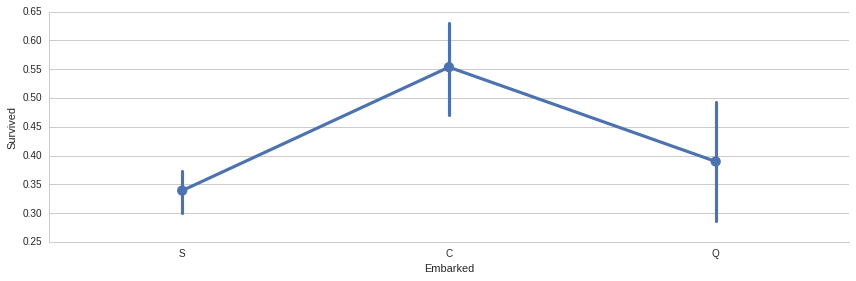

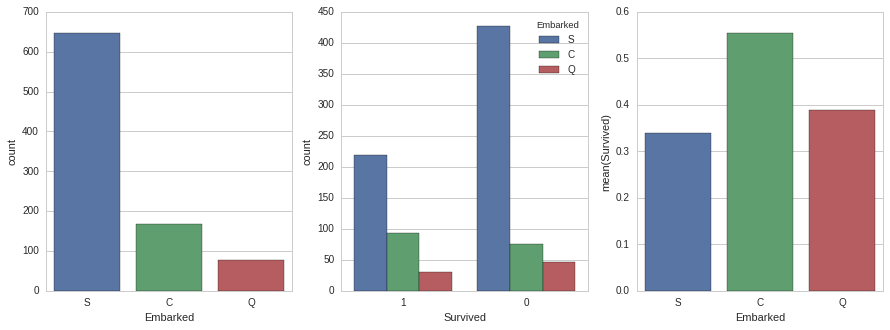

In [6]:
# Embarked

# only in titanic_df, fill the two missing values with the most occurred value, which is "S".
titanic_df["Embarked"] = titanic_df["Embarked"].fillna("S")

# plot
sns.factorplot('Embarked','Survived', data=titanic_df,size=4,aspect=3)

fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))

# sns.factorplot('Embarked',data=titanic_df,kind='count',order=['S','C','Q'],ax=axis1)
# sns.factorplot('Survived',hue="Embarked",data=titanic_df,kind='count',order=[1,0],ax=axis2)
sns.countplot(x='Embarked', data=titanic_df, ax=axis1)
sns.countplot(x='Survived', hue="Embarked", data=titanic_df, order=[1,0], ax=axis2)

# group by embarked, and get the mean for survived passengers for each value in Embarked
embark_perc = titanic_df[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis3)

# Either to consider Embarked column in predictions,
# and remove "S" dummy variable, 
# and leave "C" & "Q", since they seem to have a good rate for Survival.

# OR, don't create dummy variables for Embarked column, just drop it, 
# because logically, Embarked doesn't seem to be useful in prediction.

embark_dummies_titanic  = pd.get_dummies(titanic_df['Embarked'])
embark_dummies_titanic.drop(['S'], axis=1, inplace=True)

embark_dummies_test  = pd.get_dummies(test_df['Embarked'])
embark_dummies_test.drop(['S'], axis=1, inplace=True)

titanic_df = titanic_df.join(embark_dummies_titanic)
test_df    = test_df.join(embark_dummies_test)

titanic_df.drop(['Embarked'], axis=1,inplace=True)
test_df.drop(['Embarked'], axis=1,inplace=True)

titanic_df.head()

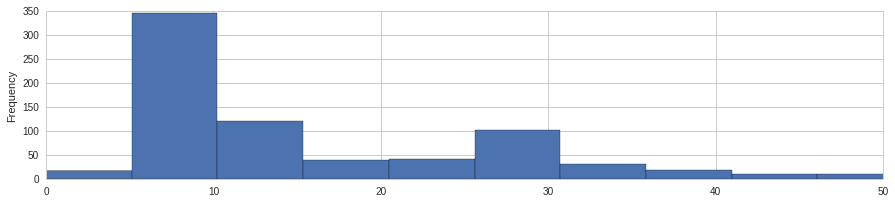

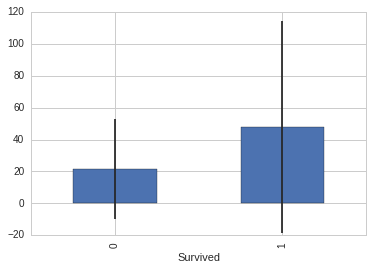

In [7]:
# Fare

# only for test_df, since there is a missing "Fare" values
test_df["Fare"].fillna(test_df["Fare"].median(), inplace=True)

# convert from float to int
titanic_df['Fare'] = titanic_df['Fare'].astype(int)
test_df['Fare']    = test_df['Fare'].astype(int)

# get fare for survived & didn't survive passengers 
fare_not_survived = titanic_df["Fare"][titanic_df["Survived"] == 0]
fare_survived     = titanic_df["Fare"][titanic_df["Survived"] == 1]

# get average and std for fare of survived/not survived passengers
avgerage_fare = DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare      = DataFrame([fare_not_survived.std(), fare_survived.std()])

# plot
titanic_df['Fare'].plot(kind='hist', figsize=(15,3),bins=100, xlim=(0,50))

avgerage_fare.index.names = std_fare.index.names = ["Survived"]
avgerage_fare.plot(yerr=std_fare,kind='bar',legend=False)

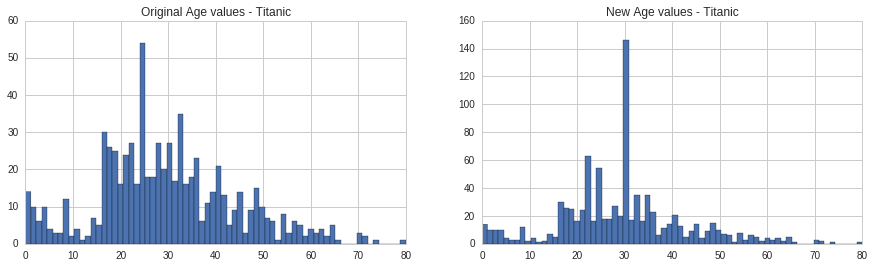

In [8]:
# Age 

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Original Age values - Titanic')
axis2.set_title('New Age values - Titanic')

# axis3.set_title('Original Age values - Test')
# axis4.set_title('New Age values - Test')

titanic_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)

median_age_mr_train = titanic_df[titanic_df['Mr']==1]['Age'].median()
median_age_mr_test = test_df[test_df['Mr']==1]['Age'].median()

titanic_df.loc[(titanic_df['Mr']==1) & (np.isnan(titanic_df["Age"])),"Age"] = median_age_mr_train
test_df.loc[(test_df['Mr']==1) & (np.isnan(test_df["Age"])),"Age"] = median_age_mr_test

median_age_miss_train = titanic_df[titanic_df['Miss']==1]['Age'].median()
median_age_miss_test = test_df[test_df['Miss']==1]['Age'].median()

titanic_df.loc[(titanic_df['Miss']==1) & (np.isnan(titanic_df["Age"])),"Age"] = median_age_miss_train
test_df.loc[(test_df['Miss']==1) & (np.isnan(test_df["Age"])),"Age"] = median_age_miss_test

median_age_mrs_train = titanic_df[titanic_df['Mrs']==1]['Age'].median()
median_age_mrs_test = test_df[test_df['Mrs']==1]['Age'].median()

titanic_df.loc[(titanic_df['Mrs']==1) & (np.isnan(titanic_df["Age"])),"Age"] = median_age_mrs_train
test_df.loc[(test_df['Mrs']==1) & (np.isnan(test_df["Age"])),"Age"] = median_age_mrs_test

median_age_rev_train = titanic_df[titanic_df['Rev']==1]['Age'].median()
median_age_rev_test = test_df[test_df['Rev']==1]['Age'].median()

titanic_df.loc[(titanic_df['Rev']==1) & np.isnan(titanic_df["Age"]),"Age"] = median_age_rev_train
test_df.loc[(test_df['Rev']==1) & (np.isnan(test_df["Age"])),"Age"] = median_age_rev_test

median_age_dr_train = titanic_df[titanic_df['Dr']==1]['Age'].median()
median_age_dr_test = test_df[test_df['Dr']==1]['Age'].median()

titanic_df.loc[(titanic_df['Dr']==1) & (np.isnan(titanic_df["Age"])),"Age"] = median_age_dr_train
test_df.loc[(test_df['Dr']==1) & (np.isnan(test_df["Age"])),"Age"] = median_age_dr_test

median_age_mil_train = titanic_df[titanic_df['Mil']==1]['Age'].median()
median_age_mil_test = test_df[test_df['Mil']==1]['Age'].median()

titanic_df.loc[(titanic_df['Mil']==1) & (np.isnan(titanic_df["Age"])),"Age"] = median_age_mil_train
test_df.loc[(test_df['Mil']==1) & (np.isnan(test_df["Age"])),"Age"] = median_age_mil_test

median_age_master_train = titanic_df[titanic_df['Master']==1]['Age'].median()
median_age_master_test = test_df[test_df['Master']==1]['Age'].median()

titanic_df.loc[(titanic_df['Master']==1) & (np.isnan(titanic_df["Age"])),"Age"] = median_age_master_train
test_df.loc[(test_df['Master']==1) & (np.isnan(test_df["Age"])),"Age"] = median_age_master_test

# convert from float to int
#print titanic_df['Age']
titanic_df['Age'] = titanic_df['Age'].astype(int)
test_df['Age']    = test_df['Age'].astype(int)
        
# plot new Age Values
titanic_df['Age'].hist(bins=70, ax=axis2)
# test_df['Age'].hist(bins=70, ax=axis4)

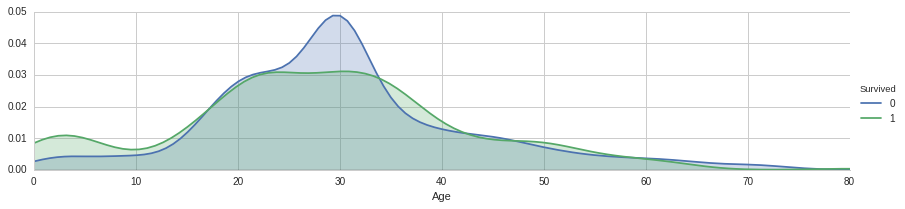

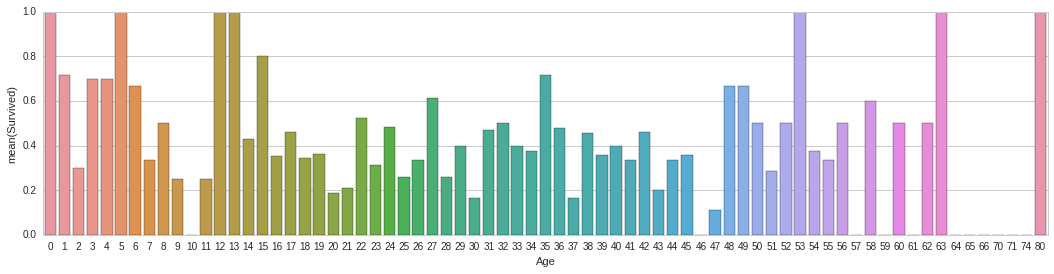

In [9]:
# .... continue with plot Age column

# peaks for survived/not survived passengers by their age
facet = sns.FacetGrid(titanic_df, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, titanic_df['Age'].max()))
facet.add_legend()

# average survived passengers by age
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_age = titanic_df[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=average_age)

In [10]:
# Cabin
# It has a lot of NaN values, so it won't cause a remarkable impact on prediction
titanic_df.drop("Cabin",axis=1,inplace=True)
test_df.drop("Cabin",axis=1,inplace=True)

# Dropping Sex as well as this is entirely accounted for in various titles
embark_dummies_titanic  = pd.get_dummies(titanic_df['Sex'])
embark_dummies_titanic.drop(['male'], axis=1, inplace=True)

embark_dummies_test  = pd.get_dummies(test_df['Sex'])
embark_dummies_test.drop(['male'], axis=1, inplace=True)

titanic_df = titanic_df.join(embark_dummies_titanic)
test_df    = test_df.join(embark_dummies_test)

titanic_df.drop(['Sex'], axis=1,inplace=True)
test_df.drop(['Sex'], axis=1,inplace=True)

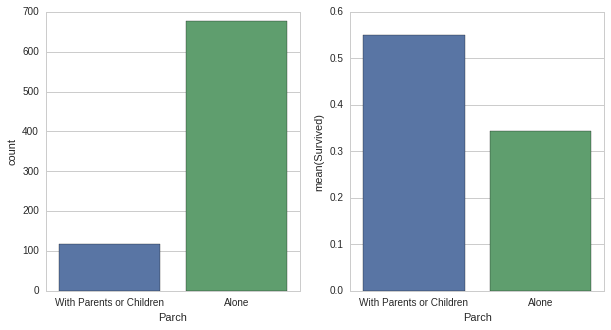

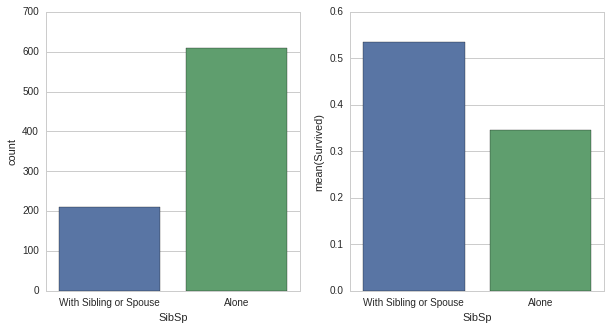

In [ ]:
# Family

# Instead of having two columns Parch & SibSp, 
# we can have only one column represent if the passenger had any family member aboard or not,
# Meaning, if having any family member(whether parent, brother, ...etc) will increase chances of Survival or not.
#titanic_df['Family'] =  titanic_df["Parch"] + titanic_df["SibSp"]
#titanic_df['Family'].loc[titanic_df['Family'] > 0] = 1
#titanic_df['Family'].loc[titanic_df['Family'] == 0] = 0

#test_df['Family'] =  test_df["Parch"] + test_df["SibSp"]
#test_df['Family'].loc[test_df['Family'] > 0] = 1
#test_df['Family'].loc[test_df['Family'] == 0] = 0

# drop Parch & SibSp
#titanic_df = titanic_df.drop(['SibSp','Parch'], axis=1)
#test_df    = test_df.drop(['SibSp','Parch'], axis=1)

# plot
fig, (axis1,axis2) = plt.subplots(1,2,sharex=True,figsize=(10,5))

# sns.factorplot('Family',data=titanic_df,kind='count',ax=axis1)
sns.countplot(x='Parch', data=titanic_df, order=[1,0], ax=axis1)

# average of survived for those who had/didn't have any family member
parch_perc = titanic_df[["Parch", "Survived"]].groupby(['Parch'],as_index=False).mean()
sns.barplot(x='Parch', y='Survived', data=parch_perc, order=[1,0], ax=axis2)

axis1.set_xticklabels(["With Parents or Children","Alone"], rotation=0)

fig2, (axis1,axis2) = plt.subplots(1,2,sharex=True,figsize=(10,5))

# sns.factorplot('Family',data=titanic_df,kind='count',ax=axis1)
sns.countplot(x='SibSp', data=titanic_df, order=[1,0], ax=axis1)

# average of survived for those who had/didn't have any family member
sibsp_perc = titanic_df[["SibSp", "Survived"]].groupby(['SibSp'],as_index=False).mean()
sns.barplot(x='SibSp', y='Survived', data=sibsp_perc, order=[1,0], ax=axis2)

axis1.set_xticklabels(["With Sibling or Spouse","Alone"], rotation=0)

In [ ]:
# Pclass

# sns.factorplot('Pclass',data=titanic_df,kind='count',order=[1,2,3])
sns.factorplot('Pclass','Survived',order=[1,2,3], data=titanic_df,size=5)

# create dummy variables for Pclass column, & drop 3rd class as it has the lowest average of survived passengers
pclass_dummies_titanic  = pd.get_dummies(titanic_df['Pclass'])
pclass_dummies_titanic.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_titanic.drop(['Class_3'], axis=1, inplace=True)

pclass_dummies_test  = pd.get_dummies(test_df['Pclass'])
pclass_dummies_test.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_test.drop(['Class_3'], axis=1, inplace=True)

titanic_df.drop(['Pclass'],axis=1,inplace=True)
test_df.drop(['Pclass'],axis=1,inplace=True)

titanic_df = titanic_df.join(pclass_dummies_titanic)
test_df    = test_df.join(pclass_dummies_test)

In [ ]:
# define training and testing sets

X_train = titanic_df.drop("Survived",axis=1)
Y_train = titanic_df["Survived"]
X_test  = test_df.drop("PassengerId",axis=1).copy()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

accuracy_scorer = make_scorer(accuracy_score)

# Random Forests

random_forest = RandomForestClassifier(n_estimators=100,criterion='entropy')

#random_forest.fit(X_train, Y_train)

parameters = {'max_depth':[5,6,7], 'min_samples_split':[12,13,14,15,16,17,18], 'n_estimators':[45,50,55,60,65,70,75]}
grid_search_CV = GridSearchCV(random_forest, parameters, cv=40, scoring=accuracy_scorer, verbose=10)
grid_search_CV.fit(X_train, Y_train)
print("score equals %f" % (grid_search_CV.best_score_))
print("%s" % (grid_search_CV.best_params_))
random_forest = grid_search_CV.best_estimator_

Y_pred_rf = random_forest.predict(X_test)

rf_score = random_forest.score(X_train, Y_train)

print(rf_score)

In [ ]:
# put ensemble together
#total_score = knn_score + rf_score + svc_score + logreg_score

#Y_pred_avg = (1./5.) * Y_pred_knn + (1./5.) * Y_pred_rf + (0.35) * Y_pred_svc + (0.25) * Y_pred_ab
Y_pred_avg = Y_pred_rf
#Y_pred_avg = Y_pred_svc
#Y_pred_avg = Y_pred_knn
#Y_pred_avg = Y_pred_ab
Y_pred = list(map(lambda x: 0 if x < 0.5 else 1, Y_pred_avg))

In [ ]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('titanic.csv', index=False)